## Chapter 9. 비지도 학습

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 9.1 Cluster

In [3]:
# 예제 데이터 생성
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [4]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

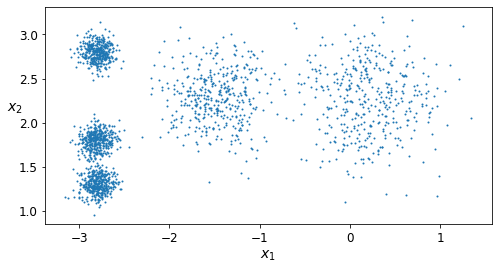

In [5]:

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [24]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=2022)
y_pred = kmeans.fit_predict(X)
y_pred

array([2, 4, 0, ..., 1, 0, 4])

In [25]:
y_pred is kmeans.labels_

True

In [26]:
# centroid
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

In [27]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 1, 1])

#### Plot k-Means Decision boundary

In [28]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

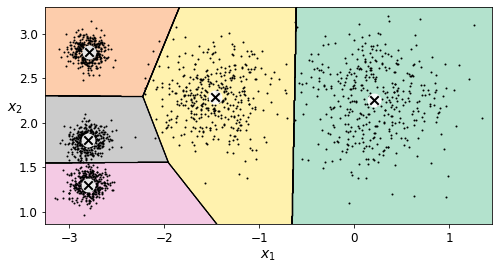

In [29]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [30]:
# 하드 군집 vs 소프트 군집
# 하드 군집은 각 샘플에 대해 가장 가까운 클러스터를 선택하는데, 이 대신 샘플에서 5개 센트로이드까지 거리를 측정하는 것이 나을 수 있음
# transform() 메서드에서 이 거리를 계산
kmeans.transform(X_new)

array([[0.32995317, 2.9042344 , 2.88633901, 1.49439034, 2.81093633],
       [2.80290755, 5.84739223, 5.84236351, 4.4759332 , 5.80730058],
       [3.29399768, 0.29040966, 1.71086031, 1.69136631, 1.21475352],
       [3.21806371, 0.36159148, 1.21567622, 1.54808703, 0.72581411]])

In [31]:
# 위 거리가 샘플과 센트로이드 사이의 유클리드 거리인지 확인
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.32995317, 2.9042344 , 2.88633901, 1.49439034, 2.81093633],
       [2.80290755, 5.84739223, 5.84236351, 4.4759332 , 5.80730058],
       [3.29399768, 0.29040966, 1.71086031, 1.69136631, 1.21475352],
       [3.21806371, 0.36159148, 1.21567622, 1.54808703, 0.72581411]])

In [13]:
# 센트로이드 초기화 방법
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)

In [32]:
# KMeans 이너셔 확인
kmeans.inertia_

211.5985372581684

In [33]:
# 좋은 결과물일수록 높은 수가 되어야 하므로, 음수값으로 처리됨
kmeans.score(X)

-211.5985372581684

In [34]:
# k-평균 속도 개선과 미니배치 k-평균
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(n_clusters=5)